# TCC - Modelo de Predição AVC
- Engenharia da Computação 10º Semestre e Ciência da Computação 8º Semestre - FAM Centro Universitário das Américas
- Alunos:
  - PEDRO HENRIQUE DE ALMEIDA SOUSA, 152918
  - DOUGLAS FÉLIX PHILIPINI SANTOS, 155608
  - NICOLAS RODRIGUES SILVA, 167315
  - IRIS CAPPARELLA WAGNER, 198165

## Importando bibliotecas e lendo a base do Kaggle

In [0]:
pip install -U imbalanced-learn


Python interpreter will be restarted.
Python interpreter will be restarted.


In [0]:
pip install scikit-optimize

Python interpreter will be restarted.
Python interpreter will be restarted.


In [0]:
from pyspark.sql.functions import *
import pandas as pd
from statistics import mean
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import RFE

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import *

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.under_sampling import RandomUnderSampler


import numpy as np
import random


from sklearn.model_selection import cross_val_predict, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler


from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

import pickle

In [0]:
arquivo = '/FileStore/tables/healthcare_dataset_stroke_data.csv'
file_type = 'csv'

# CSV options
infer_schema = "false"
first_row_is_header = "true"
delimiter = ","

# The applied options are for CSV files. For other file types, these will be ignored.
df = spark.read.format(file_type) \
  .option("inferSchema", infer_schema) \
  .option("header", first_row_is_header) \
  .option("sep", delimiter) \
  .load(arquivo)

display(df.limit(10))

id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
9046,Male,67,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
51676,Female,61,0,0,Yes,Self-employed,Rural,202.21,N/A,never smoked,1
31112,Male,80,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
60182,Female,49,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
1665,Female,79,1,0,Yes,Self-employed,Rural,174.12,24,never smoked,1
56669,Male,81,0,0,Yes,Private,Urban,186.21,29,formerly smoked,1
53882,Male,74,1,1,Yes,Private,Rural,70.09,27.4,never smoked,1
10434,Female,69,0,0,No,Private,Urban,94.39,22.8,never smoked,1
27419,Female,59,0,0,Yes,Private,Rural,76.15,N/A,Unknown,1
60491,Female,78,0,0,Yes,Private,Urban,58.57,24.2,Unknown,1


In [0]:
df.printSchema()

root
 |-- id: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- age: string (nullable = true)
 |-- hypertension: string (nullable = true)
 |-- heart_disease: string (nullable = true)
 |-- ever_married: string (nullable = true)
 |-- work_type: string (nullable = true)
 |-- Residence_type: string (nullable = true)
 |-- avg_glucose_level: string (nullable = true)
 |-- bmi: string (nullable = true)
 |-- smoking_status: string (nullable = true)
 |-- stroke: string (nullable = true)



#### Renomeando colunas e alterando tipagem

In [0]:
df_spark_tratado = df.select(
    col('id').alias('ID').cast('integer'),
    col('gender').alias('GENERO'),
    col('age').alias('IDADE').cast('integer'),
    col('hypertension').alias('HIPERTENSO').cast('integer'),
    col('heart_disease').alias('DOENCA_CARDIACA').cast('integer'),
    col('ever_married').alias('JA_FOI_CASADO'),
    col('work_type').alias('PROFISSAO'),
    col('Residence_type').alias('RESIDENCIA'),
    col('avg_glucose_level').alias('NIVEL_MEDIO_GLICOSE').cast('double'),
    col('bmi').alias('IMC').cast('double'),
    col('smoking_status').alias('FUMA'),
    col('stroke').alias('AVC').cast('integer')
)

display(df_spark_tratado.limit(10))

ID,GENERO,IDADE,HIPERTENSO,DOENCA_CARDIACA,JA_FOI_CASADO,PROFISSAO,RESIDENCIA,NIVEL_MEDIO_GLICOSE,IMC,FUMA,AVC
9046,Male,67,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
51676,Female,61,0,0,Yes,Self-employed,Rural,202.21,null,never smoked,1
31112,Male,80,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
60182,Female,49,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
1665,Female,79,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
56669,Male,81,0,0,Yes,Private,Urban,186.21,29.0,formerly smoked,1
53882,Male,74,1,1,Yes,Private,Rural,70.09,27.4,never smoked,1
10434,Female,69,0,0,No,Private,Urban,94.39,22.8,never smoked,1
27419,Female,59,0,0,Yes,Private,Rural,76.15,null,Unknown,1
60491,Female,78,0,0,Yes,Private,Urban,58.57,24.2,Unknown,1


## Análise Exploratória

In [0]:
#Quantidade de pessoas que sofreram AVC

df_spark_tratado.groupBy('AVC').count().show()

+---+-----+
|AVC|count|
+---+-----+
|  1|  249|
|  0| 4861|
+---+-----+



In [0]:
df_spark_tratado.groupBy('FUMA').count().show()

+---------------+-----+
|           FUMA|count|
+---------------+-----+
|         smokes|  789|
|        Unknown| 1544|
|   never smoked| 1892|
|formerly smoked|  885|
+---------------+-----+



In [0]:
df_spark_tratado.groupBy('RESIDENCIA').count().show()

+----------+-----+
|RESIDENCIA|count|
+----------+-----+
|     Urban| 2596|
|     Rural| 2514|
+----------+-----+



In [0]:
df_spark_tratado.groupBy('PROFISSAO').count().show()

+-------------+-----+
|    PROFISSAO|count|
+-------------+-----+
| Never_worked|   22|
|Self-employed|  819|
|      Private| 2925|
|     children|  687|
|     Govt_job|  657|
+-------------+-----+



In [0]:
df_spark_tratado.groupBy('JA_FOI_CASADO').count().show()

+-------------+-----+
|JA_FOI_CASADO|count|
+-------------+-----+
|           No| 1757|
|          Yes| 3353|
+-------------+-----+



In [0]:
df_spark_tratado.groupBy('GENERO').count().show()

+------+-----+
|GENERO|count|
+------+-----+
|Female| 2994|
| Other|    1|
|  Male| 2115|
+------+-----+



In [0]:
df_spark_tratado.groupBy('HIPERTENSO').count().show()

+----------+-----+
|HIPERTENSO|count|
+----------+-----+
|         1|  498|
|         0| 4612|
+----------+-----+



In [0]:
#Transformando em Pandas para realizar as análises gráficas e preparar o modelo.

df_pd = df_spark_tratado.toPandas()

In [0]:
#substituir daqui
df_pd\
.describe(percentiles = [0.25, 0.5, 0.75, 0.8, 0.9])\
.T\
.drop(columns=['count'])\
.style\
.background_gradient(axis=1)\
.savefig('summary.png', format='png')
#até aqui

Out[17]: <AxesSubplot:xlabel='AVC', ylabel='NIVEL_MEDIO_GLICOSE'>

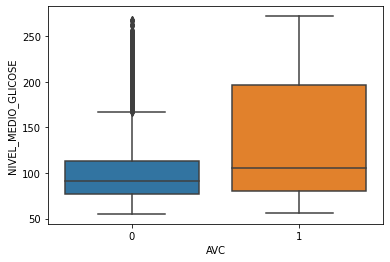

In [0]:
sns.boxplot(data = df_pd, x="AVC", y="NIVEL_MEDIO_GLICOSE")

Out[18]: <AxesSubplot:xlabel='AVC', ylabel='IMC'>

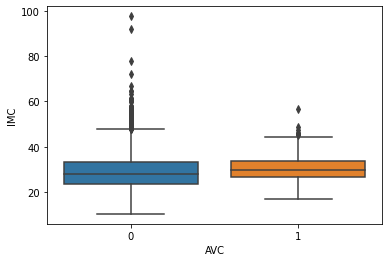

In [0]:
sns.boxplot(data = df_pd, x="AVC", y="IMC")

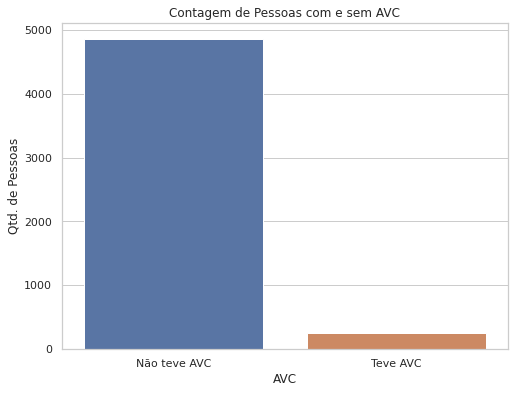

Não tiveram AVC:  4861
Tiveram AVC:  249


In [0]:
# Desbalanceamento

df_nao_teve_avc = df_pd[df_pd['AVC'] == 0]
df_teve_avc = df_pd[df_pd['AVC'] == 1]

eixo_Y = [len(df_nao_teve_avc), len(df_teve_avc)]
eixo_X = ['Não teve AVC', 'Teve AVC']

# Criar o gráfico de barras com Seaborn
sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))
sns.barplot(x=eixo_X, y=eixo_Y)

plt.xlabel('AVC')
plt.ylabel('Qtd. de Pessoas')
plt.title('Contagem de Pessoas com e sem AVC')

# Exibir o gráfico
plt.show()

print('Não tiveram AVC: ',len(df_nao_teve_avc))
print('Tiveram AVC: ', len(df_teve_avc))

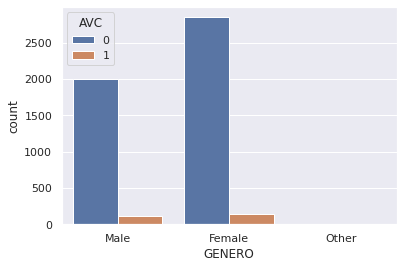

In [0]:
sns.set_style('darkgrid')
sns.countplot(data=df_pd, x='GENERO', hue='AVC')
plt.show()

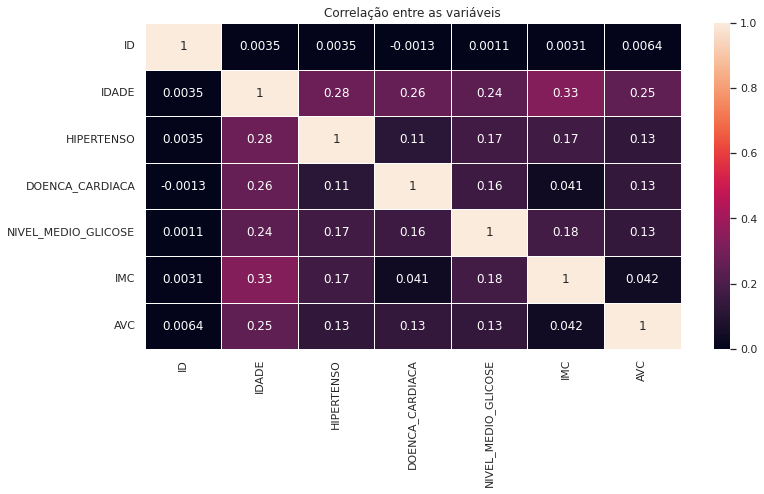

In [0]:
plt.figure(figsize=(12, 6))
 
plt.title('Correlação entre as variáveis')
 
sns.heatmap(
    df_pd.corr(), annot=True, linewidths=1
)
 
plt.show()

## Tratamento dos dados

#### Nulos e Faltantes

In [0]:
#Verificando a quantidade de valores faltantes nas variáveis da base

percentual_nulos = (df_pd.isna().sum() / len(df_pd)) * 100
display(percentual_nulos)
print('\n Quantidade de nulos da variável IMC: ',df_pd['IMC'].isna().sum())

ID                     0.000000
GENERO                 0.000000
IDADE                  0.000000
HIPERTENSO             0.000000
DOENCA_CARDIACA        0.000000
JA_FOI_CASADO          0.000000
PROFISSAO              0.000000
RESIDENCIA             0.000000
NIVEL_MEDIO_GLICOSE    0.000000
IMC                    3.933464
FUMA                   0.000000
AVC                    0.000000
dtype: float64
 Quantidade de nulos da variável IMC:  201


In [0]:
# Substituindo os valores nulos pela mediana

mediana_imc = df_pd['IMC'].median()
df_pd['IMC'].fillna(mediana_imc, inplace=True)

percentual_nulos = (df_pd.isna().sum() / len(df_pd)) * 100
display(percentual_nulos)

ID                     0.0
GENERO                 0.0
IDADE                  0.0
HIPERTENSO             0.0
DOENCA_CARDIACA        0.0
JA_FOI_CASADO          0.0
PROFISSAO              0.0
RESIDENCIA             0.0
NIVEL_MEDIO_GLICOSE    0.0
IMC                    0.0
FUMA                   0.0
AVC                    0.0
dtype: float64

In [0]:
#Codificação de variáveis categóricas

label_encoder = LabelEncoder()

df_pd['HIPERTENSO'] = label_encoder.fit_transform(df_pd['HIPERTENSO'])
df_pd['DOENCA_CARDIACA'] = label_encoder.fit_transform(df_pd['DOENCA_CARDIACA'])
df_pd['JA_FOI_CASADO'] = label_encoder.fit_transform(df_pd['JA_FOI_CASADO'])
df_pd['RESIDENCIA'] = label_encoder.fit_transform(df_pd['RESIDENCIA'])
df_pd.head()

,ID,GENERO,IDADE,HIPERTENSO,DOENCA_CARDIACA,JA_FOI_CASADO,PROFISSAO,RESIDENCIA,NIVEL_MEDIO_GLICOSE,IMC,FUMA,AVC
0,9046,Male,67,0,1,1,Private,1,228.69,36.6,formerly smoked,1
1,51676,Female,61,0,0,1,Self-employed,0,202.21,28.1,never smoked,1
2,31112,Male,80,0,1,1,Private,0,105.92,32.5,never smoked,1
3,60182,Female,49,0,0,1,Private,1,171.23,34.4,smokes,1
4,1665,Female,79,1,0,1,Self-employed,0,174.12,24.0,never smoked,1


In [0]:
#Codificação de variáveis categóricas
df_pd = pd.get_dummies(df_pd, columns=['GENERO', 'PROFISSAO', 'FUMA'], prefix='', prefix_sep='')
df_pd.head()

,ID,IDADE,HIPERTENSO,DOENCA_CARDIACA,JA_FOI_CASADO,RESIDENCIA,NIVEL_MEDIO_GLICOSE,IMC,AVC,Female,...,Other,Govt_job,Never_worked,Private,Self-employed,children,Unknown,formerly smoked,never smoked,smokes
0,9046,67,0,1,1,1,228.69,36.6,1,0,...,0,0,0,1,0,0,0,1,0,0
1,51676,61,0,0,1,0,202.21,28.1,1,1,...,0,0,0,0,1,0,0,0,1,0
2,31112,80,0,1,1,0,105.92,32.5,1,0,...,0,0,0,1,0,0,0,0,1,0
3,60182,49,0,0,1,1,171.23,34.4,1,1,...,0,0,0,1,0,0,0,0,0,1
4,1665,79,1,0,1,0,174.12,24.0,1,1,...,0,0,0,0,1,0,0,0,1,0


In [0]:
#Renomeando colunas 

df_pd['MASCULINO'] = df_pd['Male']
df_pd['FEMININO'] = df_pd['Female']
df_pd['OUTROS'] = df_pd['Other']
df_pd['TP_TRAB_FUNCIONARIO_PUBLICO'] = df_pd['Govt_job']
df_pd['TP_TRAB_NUNCA_TRABALHOU'] = df_pd['Never_worked']
df_pd['TP_TRAB_PRIVADO'] = df_pd['Private']
df_pd['TP_TRAB_AUTONOMO'] = df_pd['Self-employed']
df_pd['TP_TRAB_CRIANCA'] = df_pd['children']
df_pd['TP_TRAB_DESCONHECIDO'] = df_pd['Unknown']
df_pd['EX_FUMANTE'] = df_pd['formerly smoked']
df_pd['NUNCA_FUMOU'] = df_pd['never smoked']
df_pd['FUMANTE'] = df_pd['smokes']


df_pd.drop(columns=['Male', 'Female', 'Other', 'Govt_job', 'Never_worked', 'Private', 'Self-employed', 'children', 'Unknown', 'formerly smoked', 'never smoked', 'smokes' ], inplace=True)
df_pd.head()

,ID,IDADE,HIPERTENSO,DOENCA_CARDIACA,JA_FOI_CASADO,RESIDENCIA,NIVEL_MEDIO_GLICOSE,IMC,AVC,MASCULINO,...,OUTROS,TP_TRAB_FUNCIONARIO_PUBLICO,TP_TRAB_NUNCA_TRABALHOU,TP_TRAB_PRIVADO,TP_TRAB_AUTONOMO,TP_TRAB_CRIANCA,TP_TRAB_DESCONHECIDO,EX_FUMANTE,NUNCA_FUMOU,FUMANTE
0,9046,67,0,1,1,1,228.69,36.6,1,1,...,0,0,0,1,0,0,0,1,0,0
1,51676,61,0,0,1,0,202.21,28.1,1,0,...,0,0,0,0,1,0,0,0,1,0
2,31112,80,0,1,1,0,105.92,32.5,1,1,...,0,0,0,1,0,0,0,0,1,0
3,60182,49,0,0,1,1,171.23,34.4,1,0,...,0,0,0,1,0,0,0,0,0,1
4,1665,79,1,0,1,0,174.12,24.0,1,0,...,0,0,0,0,1,0,0,0,1,0


In [0]:
#Removendo coluna ID pois esta não será necessária para o desenvolvimento do modelo

df_pd.drop(columns=['ID'], inplace=True)

## Modelo base com dados desbalanceados
- Regressão Logística

In [0]:
# Separação de base em dois conjuntos de dados X e y

X_df = df_pd[['IDADE', 'DOENCA_CARDIACA', 'NIVEL_MEDIO_GLICOSE', 'HIPERTENSO', 'IMC' ]]
y_df = df_pd['AVC']


X_df.shape, y_df.shape

Out[3]: ((5110, 5), (5110,))

In [0]:
#Regressão logística
lr = LogisticRegression()

In [0]:
#Separação em treino e teste 

X_treino, X_teste, y_treino, y_teste = train_test_split(X_df, y_df, random_state= 1, stratify= y_df)

X_treino.shape, X_teste.shape, y_treino.shape, y_teste.shape

Out[6]: ((3832, 5), (1278, 5), (3832,), (1278,))

In [0]:
#Treinando o modelo
lr.fit(X_treino, y_treino)

Out[14]: LogisticRegression()

In [0]:
#Dados de teste
y_pred = lr.predict(X_teste)

/databricks/python/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/databricks/python/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/databricks/python/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/databricks/python/lib/python3.9/site-packages/sklearn/metrics/_

Classification Report:
              precision    recall  f1-score   support

         0.0       0.95      1.00      0.98      1216
         1.0       0.00      0.00      0.00        62

    accuracy                           0.95      1278
   macro avg       0.48      0.50      0.49      1278
weighted avg       0.91      0.95      0.93      1278

Confusion Matrix:
[[1216    0]
 [  62    0]]


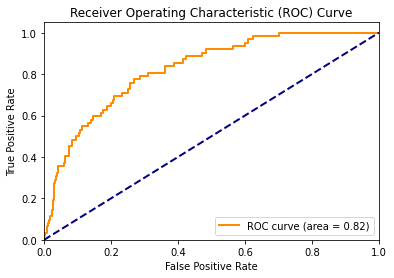

In [0]:
y_proba = lr.predict_proba(X_teste)

accuracy = accuracy_score(y_teste, y_pred)
precision = precision_score(y_teste, y_pred)
recall = recall_score(y_teste, y_pred)
f1 = f1_score(y_teste, y_pred)
conf_matrix = confusion_matrix(y_teste, y_pred)

print("Classification Report:")
print(classification_report(y_teste, y_pred))

print("Confusion Matrix:")
print(conf_matrix)

# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_teste, y_proba[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

## Balanceamento dos dados, escalonamento e execução de modelos finais

#### Feature Selection

In [0]:
#Técnica de seleção de feature 1

estimator = DecisionTreeClassifier()
selector = RFE(estimator, n_features_to_select=4, step=1)

selector = selector.fit(X, y)


feature_ranking = list(zip(X.columns, selector.ranking_))


feature_ranking.sort(key=lambda x: x[1])
for feature, ranking in feature_ranking:
    print(f"{feature}: {ranking}")

IDADE: 1
NIVEL_MEDIO_GLICOSE: 1
IMC: 1
FEMININO: 1
FUMANTE: 2
NUNCA_FUMOU: 3
RESIDENCIA: 4
HIPERTENSO: 5
TP_TRAB_DESCONHECIDO: 6
JA_FOI_CASADO: 7
TP_TRAB_AUTONOMO: 8
TP_TRAB_PRIVADO: 9
EX_FUMANTE: 10
MASCULINO: 11
TP_TRAB_FUNCIONARIO_PUBLICO: 12
DOENCA_CARDIACA: 13
TP_TRAB_NUNCA_TRABALHOU: 14
TP_TRAB_CRIANCA: 15
OUTROS: 16


In [0]:
#Técnica de seleção de feature 2

seletor_kb = SelectKBest( k=6)


seletor_kb.fit(X, y)

# Cria uma lista de nomes de colunas com os scores
scores_with_names = list(zip(X.columns, seletor_kb.scores_))

# Ordena a lista pelo score em ordem decrescente
scores_with_names.sort(key=lambda x: x[1], reverse=True)

for feature, score in scores_with_names:
    print(f"{feature}: {score}")

IDADE: 326.9165678586842
DOENCA_CARDIACA: 94.69840601636668
NIVEL_MEDIO_GLICOSE: 90.50386961378622
HIPERTENSO: 84.95354215995648
JA_FOI_CASADO: 60.66722965592002
TP_TRAB_CRIANCA: 36.18447027116253
EX_FUMANTE: 21.37627709292316
TP_TRAB_AUTONOMO: 19.818465653158768
TP_TRAB_DESCONHECIDO: 16.006798643981888
IMC: 6.669167721121732
RESIDENCIA: 1.2208416612472808
TP_TRAB_NUNCA_TRABALHOU: 1.1316090036554771
TP_TRAB_PRIVADO: 0.7220163728907096
MASCULINO: 0.42462501301595973
FEMININO: 0.4162314391336458
FUMANTE: 0.4082095998083082
NUNCA_FUMOU: 0.08707277713000791
OUTROS: 0.05121451523278003
TP_TRAB_FUNCIONARIO_PUBLICO: 0.036597790695700266



#### Balanceamento


##### StandardScaller + SMOTE

####### Regressão Logistica

In [0]:
sm = SMOTE(sampling_strategy= 0.40)


X, y = sm.fit_resample(X_df, y_df)

scaler = StandardScaler()
X_transformed = scaler.fit_transform(X)

X.shape, y.shape

Out[12]: ((6805, 5), (6805,))

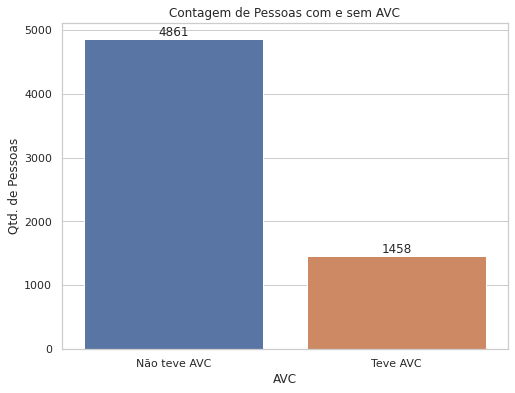

Não teve AVC: 4861
Teve AVC: 1458


In [0]:
# Filtrar os dados balanceados para pessoas que tiveram ou não AVC
df_balanceado = pd.DataFrame(X, columns=X.columns)
df_balanceado['AVC'] = y

df_nao_teve_avc = df_balanceado[df_balanceado['AVC'] == 0]
df_teve_avc = df_balanceado[df_balanceado['AVC'] == 1]

# Contar o número de pessoas em cada categoria
qtd_nao_teve_avc = len(df_nao_teve_avc)
qtd_teve_avc = len(df_teve_avc)

# Preparar dados para o gráfico
eixo_Y = [qtd_nao_teve_avc, qtd_teve_avc]
eixo_X = ['Não teve AVC', 'Teve AVC']

# Criar o gráfico de barras com Seaborn
sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))
sns.barplot(x=eixo_X, y=eixo_Y)

plt.xlabel('AVC')
plt.ylabel('Qtd. de Pessoas')
plt.title('Contagem de Pessoas com e sem AVC')

# Adicionar legendas ao gráfico
plt.text(0, qtd_nao_teve_avc, str(qtd_nao_teve_avc), ha='center', va='bottom')
plt.text(1, qtd_teve_avc, str(qtd_teve_avc), ha='center', va='bottom')

# Exibir o gráfico
plt.show()

# Exibir o número de pessoas com e sem AVC
print('Não teve AVC:', qtd_nao_teve_avc)
print('Teve AVC:', qtd_teve_avc)

In [0]:
X_treino, X_teste, y_treino, y_teste = train_test_split(X_transformed, y, random_state= 1, stratify= y)

Classification Report:
              precision    recall  f1-score   support

         0.0       0.83      0.88      0.86      1216
         1.0       0.66      0.56      0.61       486

    accuracy                           0.79      1702
   macro avg       0.75      0.72      0.73      1702
weighted avg       0.78      0.79      0.79      1702

Confusion Matrix:
[[1073  143]
 [ 213  273]]


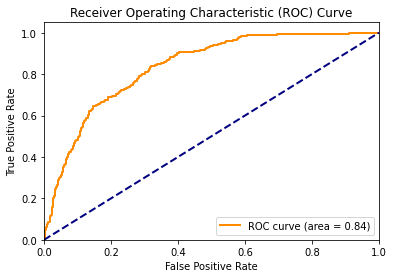

In [0]:
lr.fit(X_treino, y_treino)

y_pred = lr.predict(X_teste)

y_proba = lr.predict_proba(X_teste)

accuracy = accuracy_score(y_teste, y_pred)
precision = precision_score(y_teste, y_pred)
recall = recall_score(y_teste, y_pred)
f1 = f1_score(y_teste, y_pred)
conf_matrix = confusion_matrix(y_teste, y_pred)

print("Classification Report:")
print(classification_report(y_teste, y_pred))

print("Confusion Matrix:")
print(conf_matrix)

# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_teste, y_proba[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

####### Random Forest

In [0]:
rf = RandomForestClassifier()

Melhores Hiperparâmetros: OrderedDict([('bootstrap', False), ('max_depth', 15), ('max_features', 'sqrt'), ('min_samples_leaf', 1), ('min_samples_split', 2), ('n_estimators', 300)])
Classification Report:
              precision    recall  f1-score   support

         0.0       0.90      0.91      0.90      1216
         1.0       0.76      0.74      0.75       486

    accuracy                           0.86      1702
   macro avg       0.83      0.83      0.83      1702
weighted avg       0.86      0.86      0.86      1702

Confusion Matrix:
[[1102  114]
 [ 124  362]]


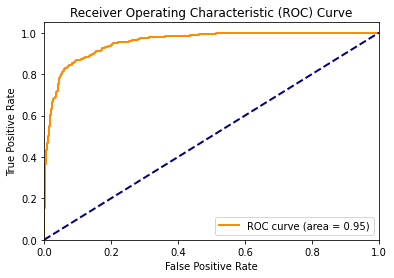

In [0]:

# Defina os limites dos hiperparâmetros para otimização
param_space = {
    'n_estimators': Integer(100, 300),
    'max_depth': Integer(1, 20),
    'min_samples_split': Integer(2, 10),
    'min_samples_leaf': Integer(1, 4),
    'max_features': Categorical(['auto', 'sqrt', 'log2']),
    'bootstrap': Categorical([True, False])
}

# Inicialize o BayesSearchCV
clf = BayesSearchCV(rf, search_spaces= param_space, n_iter=30, random_state=1, scoring='f1', n_jobs=-1,cv=5)
clf.fit(X_treino, y_treino)

# Extraindo os melhores hiperparâmetros
best_params = clf.best_params_

# Criando o modelo com os melhores hiperparâmetros encontrados
rf_model = RandomForestClassifier(**best_params)

# Treinando o modelo
rf_model.fit(X_treino, y_treino)



#y_pred = rf_model.predict(X_teste)

# Prevendo as classes com cross-validation
y_pred = cross_val_predict(rf_model, X_teste, y_teste, cv=5)
y_proba = rf_model.predict_proba(X_teste)

accuracy = accuracy_score(y_teste, y_pred)
precision = precision_score(y_teste, y_pred)
recall = recall_score(y_teste, y_pred)
f1 = f1_score(y_teste, y_pred)
conf_matrix = confusion_matrix(y_teste, y_pred)

print("Melhores Hiperparâmetros:", best_params)
print("Classification Report:")
print(classification_report(y_teste, y_pred))

print("Confusion Matrix:")
print(conf_matrix)

# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_teste, y_proba[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

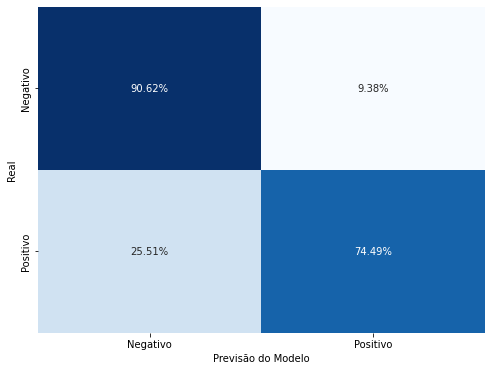

In [0]:
conf_matrix_percent = conf_matrix / conf_matrix.sum(axis=1)[:, np.newaxis]

# Plotar a matriz de confusão em percentagens
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_percent, annot=True, fmt=".2%", cmap="Blues", cbar=False, xticklabels=["Negativo", "Positivo"], yticklabels=["Negativo", "Positivo"])
plt.xlabel("Previsão do Modelo")
plt.ylabel("Real")


# Salvar a imagem em PNG
plt.savefig("matriz_confusao.png", bbox_inches="tight", dpi=300)
plt.show()

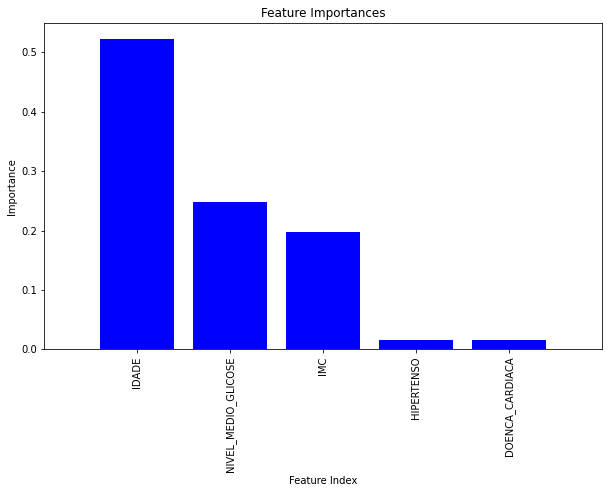

In [0]:
feature_names = X_df.columns

# Plotando o gráfico de importância das features
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(X_transformed.shape[1]), importances[indices], color="b", align="center")
plt.xticks(range(X_transformed.shape[1]),  feature_names[indices], rotation=90)
plt.xlim([-1, X_transformed.shape[1]])
plt.xlabel("Feature Index")
plt.ylabel("Importance")
plt.show()

# # Obtendo os nomes das variáveis
# feature_names = X_df.columns

# # Plotando o gráfico de importância das features
# importances = rf.feature_importances_
# indices = np.argsort(importances)[::-1]
# plt.figure(figsize=(10, 6))
# plt.title("Feature Importances")
# plt.bar(range(X_rescaled.shape[1]), importances[indices], color="b", align="center")
# plt.xticks(range(X_rescaled.shape[1]), feature_names[indices], rotation=90)
# plt.xlim([-1, X_rescaled.shape[1]])
# plt.xlabel("Feature")
# plt.ylabel("Importance")
# plt.show()

## Resultado final protótipo

In [0]:
with open('modelo_avc_randomforest_v2.pkl', 'wb') as model_file:
    pickle.dump(rf_model, model_file)

In [0]:
df_teste = df_pd[['IDADE', 'DOENCA_CARDIACA', 'NIVEL_MEDIO_GLICOSE', 'HIPERTENSO', 'IMC' ]]

df_teste.display()

IDADE,DOENCA_CARDIACA,NIVEL_MEDIO_GLICOSE,HIPERTENSO,IMC
67.0,1,228.69,0,36.6
61.0,0,202.21,0,28.1
80.0,1,105.92,0,32.5
49.0,0,171.23,0,34.4
79.0,0,174.12,1,24.0
81.0,0,186.21,0,29.0
74.0,1,70.09,1,27.4
69.0,0,94.39,0,22.8
59.0,0,76.15,0,28.1
78.0,0,58.57,0,24.2


In [0]:

with open('modelo_avc_randomforest_v2.pkl', 'rb') as model_file:
    model = pickle.load(model_file)

def predict_avc_chance(data):
    # Realizar previsões
    predictions = model.predict_proba(data)
    # Adicionar asprevisões como uma nova coluna ao DataFrame de entrada
    data['Chance de AVC (%)'] = predictions[:, 1] * 100  # Probabilidade de AVC
    return data

# Dados de exemplo (substitua isso pelos seus dados reais)
# Supondo que df_teste seja seu DataFrame original

# Criar um DataFrame com os dados de exemplo
df = df_teste

# Calculando a correlação entre 'Idade' e 'Chance de AVC (%)'
correlation = df['IDADE'].corr(df['Chance de AVC (%)'])

print("Correlação entre 'Idade' e 'Chance de AVC (%)':", correlation)

# Investigação mais detalhada
print(df[['Idade', 'Chance de AVC (%)']].head(10))

# Fazer previsões
output_data = predict_avc_chance(df.copy())

# Exibir os resultados
print(output_data[['Idade', 'Chance de AVC (%)']].head(10))

# Calculando a correlação entre 'Idade' e 'Chance de AVC (%)'
correlation = output_data['Idade'].corr(output_data['Chance de AVC (%)'])

print("Correlação entre 'Idade' e 'Chance de AVC (%)':", correlation)

# Exibir os resultados
print(output_data[['Idade', 'Chance de AVC (%)']].head(10))


---------------------------------------------------------------------------
FileNotFoundError                         Traceback (most recent call last)
File <command-3665755928334710>:1
----> 1 with open('modelo_avc_randomforest_v2.pkl', 'rb') as model_file:
      2     model = pickle.load(model_file)
      4 def predict_avc_chance(data):
      5     # Realizar previsões

FileNotFoundError: [Errno 2] No such file or directory: 'modelo_avc_randomforest_v2.pkl'